In [15]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Task 1: EDA

The goal is to explore the use of environmental sensor data to identify conditions that can signal health emergencies or distress of elderly living alone.

Before performing EDA, there are assumptions based on the dataset structure and project context where:
- **Indoor Monitoring**: All sensor readings were collected from devices installed **inside elderly residents' homes**, not external environments.
- **Sensor Placement Consistency**: All homes have sensors placed in a consistent configuration and layout, or differences are negligible.
- **Time Representation**: `"Time of Day"` is categorical (morning, afternoon, evening) and **not a timestamp**, so fine-grained temporal analysis is limited.
- **Session ID = Time Proxy**: We assume `"Session ID"` can be used as a **chronological proxy** for time progression or monitoring cycles.
- **Ambient Light Level** represents lighting inside the home, which may be influenced by natural sunlight or indoor lighting.
- **Activity Level** is collected from non-invasive observation, and labeling may contain noise eg. inconsistent use of labels like 'low activity', 'lowactivity'.
- **C02 and CO Sensor Validity**: C02 readings may increase due to poor ventilation or presence of multiple occupants. CO spikes may indicate cooking appliance usage or hazardous air quality.
- **Metal Oxide Sensors** detect other volatile organic compounds or pollutants and are expected to correlate with poor air quality or combustion byproducts.
- **HVAC Operation Mode** provides contextual clues about air circulation and system usage, which may influence temperature and humidity trends.

These assumptions guided how we cleaned, interpreted, and visualized the dataset in the following sections.

# Steps:
1. Load and preview dataset
2. Check for missing values and data types
3. Clean cateogirlca fields
4. Describe the distriibution of numerical features (temperature, humidity, Co2)
5. Explore correlation between features
6. Explore patterns based on Time of Day, Activity Level, HVAC Operation Mode

In [16]:
dataset = sqlite3.connect('gas_monitoring.db')
df = pd.read_sql_query("SELECT * FROM gas_monitoring", dataset)
dataset.close()
df.head()

,Time of Day,Temperature,Humidity,CO2_InfraredSensor,CO2_ElectroChemicalSensor,MetalOxideSensor_Unit1,MetalOxideSensor_Unit2,MetalOxideSensor_Unit3,MetalOxideSensor_Unit4,CO_GasSensor,Session ID,HVAC Operation Mode,Ambient Light Level,Activity Level
0,morning,19.63,53.83,125.49,571.09,478.55,735.85,497.59,565.05,medium,7241,off,very_dim,Low Activity
1,morning,19.66,53.69,126.34,575.79,491.96,740.28,NaN,557.08,low,7241,ventilation_only,bright,Low Activity
2,night,20.95,54.12,119.34,556.53,437.50,718.34,NaN,612.62,medium,9385,off,None,Low Activity
3,morning,20.10,50.48,113.50,NaN,515.14,744.02,676.15,600.22,low,7241,eco_mode,very_bright,High Activity
4,morning,19.89,48.42,92.77,613.65,535.66,770.27,720.27,625.73,low,7241,Heating_active,moderate,Low Activity


In [17]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time of Day                10000 non-null  object 
 1   Temperature                10000 non-null  float64
 2   Humidity                   10000 non-null  float64
 3   CO2_InfraredSensor         10000 non-null  float64
 4   CO2_ElectroChemicalSensor  9294 non-null   float64
 5   MetalOxideSensor_Unit1     10000 non-null  float64
 6   MetalOxideSensor_Unit2     10000 non-null  float64
 7   MetalOxideSensor_Unit3     7434 non-null   float64
 8   MetalOxideSensor_Unit4     10000 non-null  float64
 9   CO_GasSensor               8631 non-null   object 
 10  Session ID                 10000 non-null  int64  
 11  HVAC Operation Mode        10000 non-null  object 
 12  Ambient Light Level        7468 non-null   object 
 13  Activity Level             10000 non-null  obje

,Time of Day,Temperature,Humidity,CO2_InfraredSensor,CO2_ElectroChemicalSensor,MetalOxideSensor_Unit1,MetalOxideSensor_Unit2,MetalOxideSensor_Unit3,MetalOxideSensor_Unit4,CO_GasSensor,Session ID,HVAC Operation Mode,Ambient Light Level,Activity Level
count,10000,10000.000000,10000.000000,10000.000000,9294.000000,10000.000000,10000.000000,7434.000000,10000.000000,8631,10000.000000,10000,7468,10000
unique,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,23,5,6
top,afternoon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low,NaN,cooling_active,very_bright,Low Activity
freq,2605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4346,NaN,1504,2857,5231
mean,NaN,42.564132,51.125461,110.356504,578.333884,470.363051,728.265041,681.359029,611.956357,NaN,5418.640400,NaN,NaN,NaN
std,NaN,74.350143,20.565964,25.056797,22.669681,51.353223,43.303414,59.994204,42.855167,NaN,2588.467375,NaN,NaN,NaN
min,NaN,14.940000,-49.660000,-14.670000,408.600000,286.830000,554.280000,457.810000,412.790000,NaN,1374.000000,NaN,NaN,NaN
25%,NaN,19.000000,47.680000,99.077500,559.225000,439.630000,707.957500,658.222500,585.555000,NaN,3074.000000,NaN,NaN,NaN
50%,NaN,20.530000,51.300000,113.100000,578.890000,468.810000,726.635000,680.085000,609.005000,NaN,5214.000000,NaN,NaN,NaN
75%,NaN,23.130000,53.850000,124.022500,595.180000,493.940000,746.492500,704.405000,635.480000,NaN,7395.000000,NaN,NaN,NaN


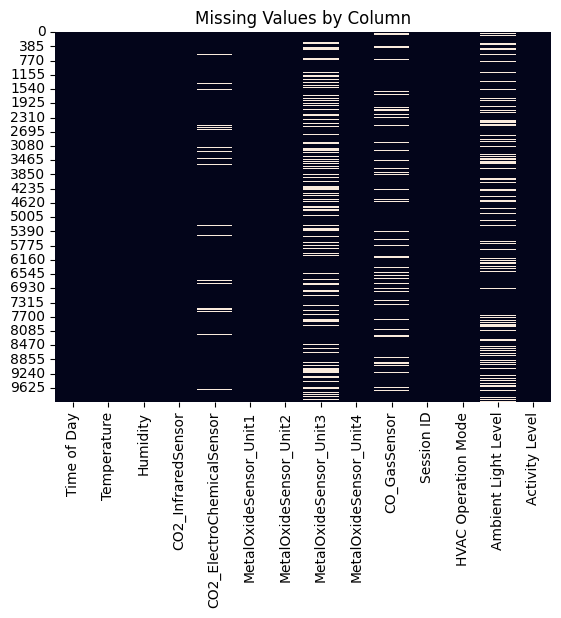

In [18]:
sns.heatmap(df.isnull(), cbar=False)
plt.title('Missing Values by Column')
plt.show()

*The heatmap of missing values can identify which variable that has systematic gaps or null enteries in the sensor based data. Given that sensor based data would encounter with malfunctions and device-level issues that can lead to missing values. This ensures that the missing values do not skew model training and help assess reliability.*

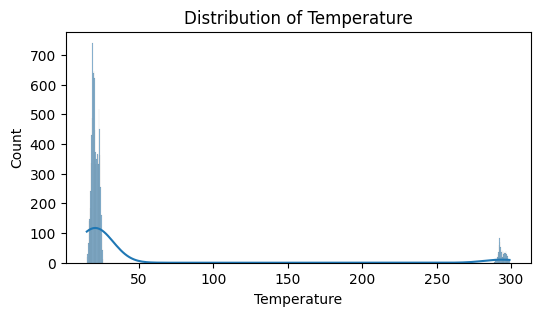

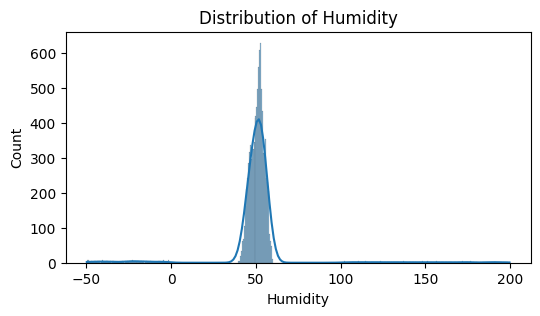

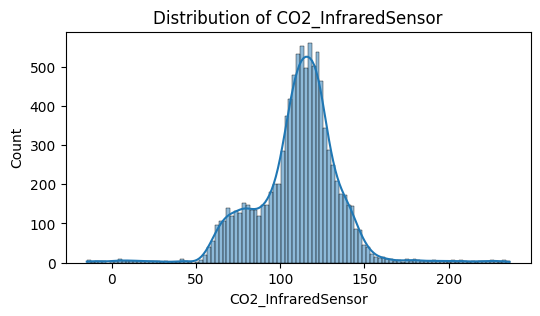

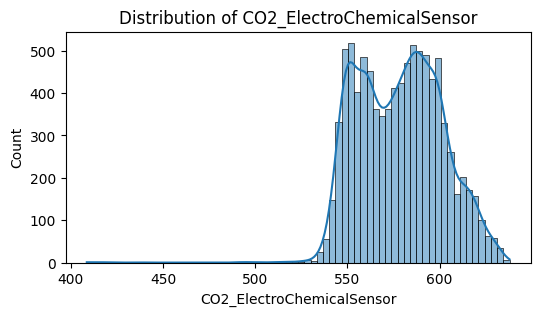

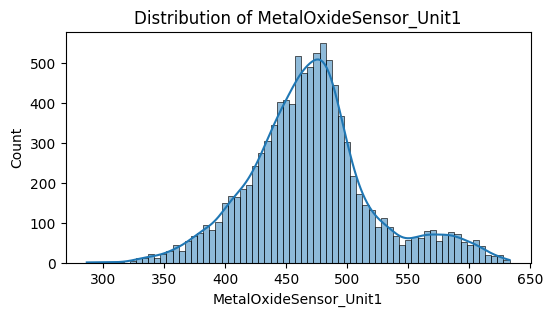

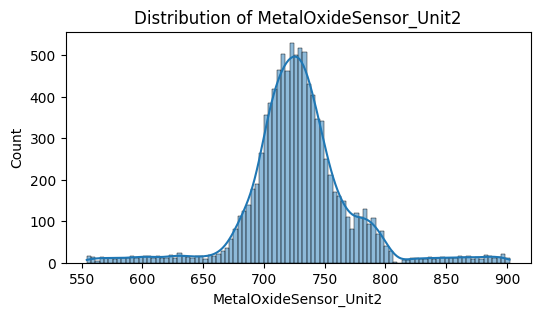

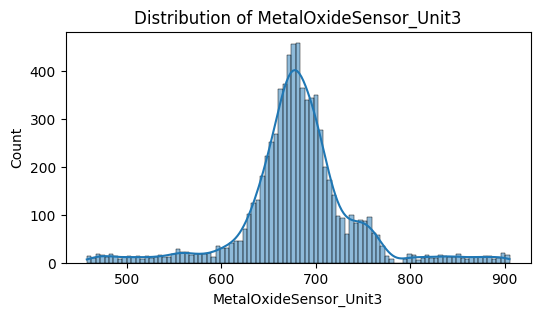

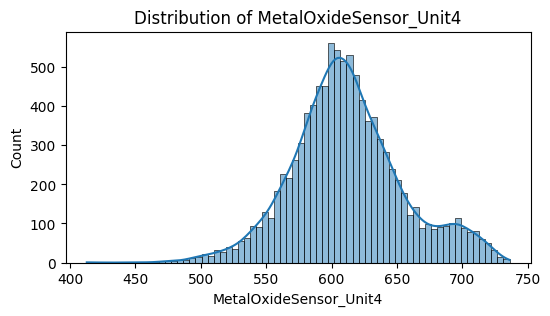

In [19]:
sensor_cols = ['Temperature', 'Humidity', 'CO2_InfraredSensor', 'CO2_ElectroChemicalSensor',
                'MetalOxideSensor_Unit1', 'MetalOxideSensor_Unit2', 'MetalOxideSensor_Unit3', 'MetalOxideSensor_Unit4']

for col in sensor_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.show()

*This graph helps to understand the shape, range and outliers of each numerical feature. It reveals the skewed distributions such as co2 concetration peaking at night. It helps us decide if we should normalize and take note of outliers.*


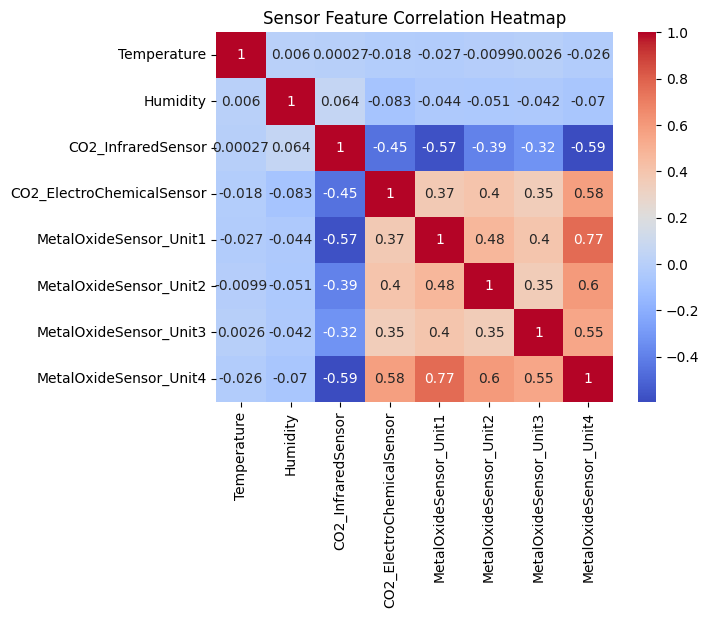

In [20]:
corr = df[sensor_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Sensor Feature Correlation Heatmap')
plt.show()

*This helps to see the relationships and redundancies between input features. As seen above, it detects the correlation and answers expected environmental relationships such as the shift of temperature/humidity with the HVAS mode.*

,Temperature,Humidity,CO2_InfraredSensor,CO2_ElectroChemicalSensor,MetalOxideSensor_Unit1,MetalOxideSensor_Unit2,MetalOxideSensor_Unit3,MetalOxideSensor_Unit4
Activity Level,,,,,,,,
High Activity,41.759917,51.455404,109.462436,583.212330,472.486535,733.435928,689.567759,620.149936
Low Activity,43.269021,51.229895,115.484018,571.788460,458.350206,719.341793,668.942841,598.080352
LowActivity,41.554881,53.275051,118.485939,573.206593,459.150990,718.326143,667.643032,596.331945
Low_Activity,45.033187,52.327692,116.628974,571.427109,455.067033,719.108864,673.794623,597.065055
Moderate Activity,41.968031,50.729412,100.910011,588.977293,492.169669,743.454245,701.707396,635.045513
ModerateActivity,37.623485,48.678534,99.223485,586.217234,492.372182,740.682085,699.744716,636.320195


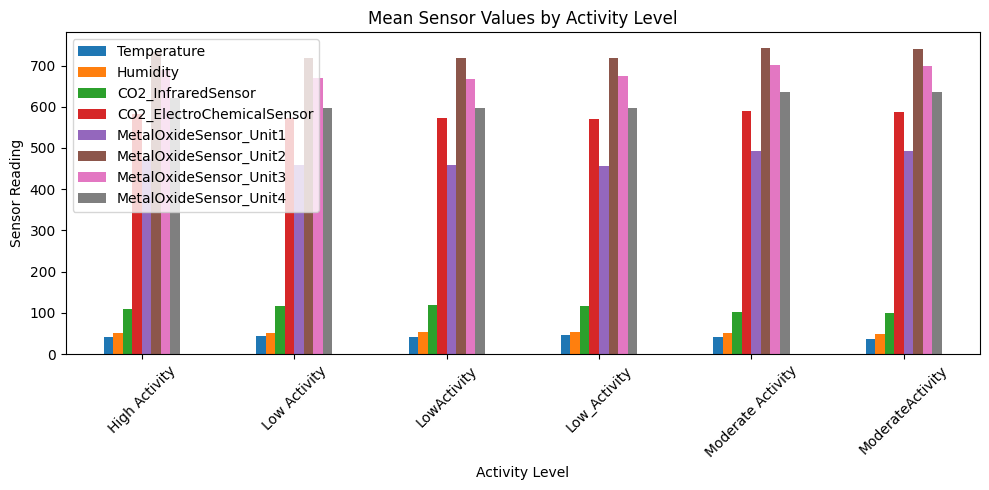

In [21]:
grouped = df.groupby('Activity Level')[sensor_cols].mean()
display(grouped)
grouped.plot(kind='bar', figsize=(10, 5))
plt.title('Mean Sensor Values by Activity Level')
plt.ylabel('Sensor Reading')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*This can be an obseravation that correlates human activity with environmental conditions which can be target variable for classification. It shows the predictive power of models such as the the if low activity occur during high CO, low loight or poor air quality. The class imbalance is observed which is telling for the feature importance.*

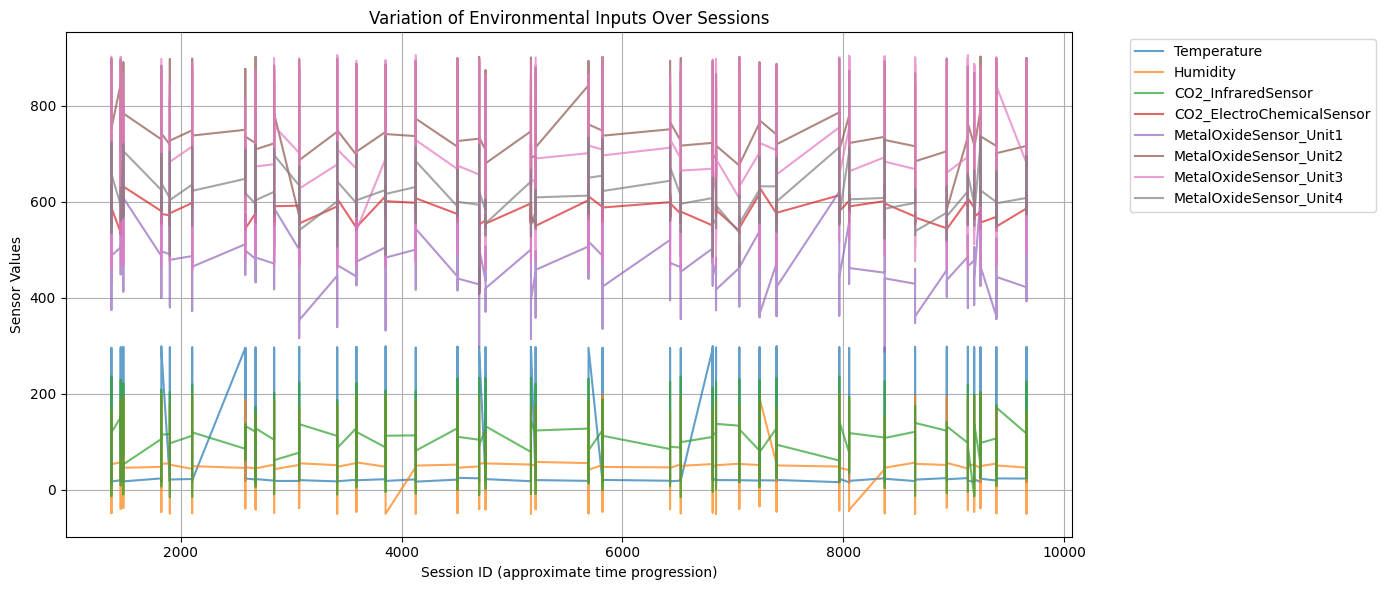

In [22]:
#create a time variation plot using 'Session ID' to approximate temporal order
sensor_cols = ['Temperature', 'Humidity', 'CO2_InfraredSensor', 'CO2_ElectroChemicalSensor',
               'MetalOxideSensor_Unit1', 'MetalOxideSensor_Unit2', 'MetalOxideSensor_Unit3', 'MetalOxideSensor_Unit4']

#convert Session ID to numeric and sort
df['Session ID'] = pd.to_numeric(df['Session ID'], errors='coerce')
df_sorted = df.sort_values(by='Session ID')

plt.figure(figsize=(14, 6))
for col in sensor_cols:
    plt.plot(df_sorted['Session ID'], df_sorted[col], label=col, alpha=0.7)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Variation of Environmental Inputs Over Sessions')
plt.xlabel('Session ID (approximate time progression)')
plt.ylabel('Sensor Values')
plt.tight_layout()
plt.grid(True)
plt.show()


*Since there is no precise time stamps, SESSION ID can approximate the temporal progression. The cyclical trends in indoor air quality can be observed with the C02 buildup over the day etc. It may capture patterns like the rise in gradual temperature with HVAC inactivity. This can be important as it supports potential time-aware model such RNN.*

## Key Findings
- **Temperature & Humidity:** Generally consistent but with notable outliers during morning/evening. High humidity linked to poor ventilation and respiratory risk.
- **CO/C02 Sensors:** High electrochemical C02 or CO levels may indicate stove use or poor air circulation.
- **Metal Oxide Sensors:** Detect broader gas pollutants which can reflect combustion or other air quality issues.
- **Light Level:** 'Very dim' light with 'low activity' during daytime may indicate a safety concern like a fall risk etc.
- **Activity Level Correlation:** Lower activity associated with higher CO and lower ambient light levels.
- **HVAC Usage:** 'Off' state in high temp/humidity environments may signal ventilation concerns.